<h1>Question 1</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed as randseed

In [2]:
class AntWalk:
    def __init__(self, m, n, seed = None):
        randseed(seed) # For reproducibility
        self.m = m
        self.n = n
        self.x = np.zeros(1, dtype = int)
        self.y = np.zeros(1, dtype = int)
        self.D_arr = np.empty(1, dtype = float)
        self.D_arr[0] = self.__walk_path()
    
    def __find_step_deviation(self, x, y):
        x_frac = x / self.m
        y_frac = y / self.n
        return abs(x_frac - y_frac)
    
    def __walk_path(self):
        self.x = np.zeros(1, dtype = int)
        self.y = np.zeros(1, dtype = int)
        D_path = 0
        while self.x[-1] < self.m or self.y[-1] < self.n:
            axis = randint(0, 1)
            if axis == 0:
                if self.x[-1] < self.m:
                    self.x = np.append(self.x, self.x[-1] + 1)
                    self.y = np.append(self.y, self.y[-1])
                else:
                    self.x = np.append(self.x, self.x[-1])
                    self.y = np.append(self.y, self.y[-1] + 1)
            elif axis == 1:
                if self.y[-1] < self.n:
                    self.x = np.append(self.x, self.x[-1])
                    self.y = np.append(self.y, self.y[-1] + 1)
                else:
                    self.x = np.append(self.x, self.x[-1] + 1)
                    self.y = np.append(self.y, self.y[-1])
            
            D_step = self.__find_step_deviation(self.x[-1], self.y[-1])
            if D_step > D_path:
                D_path = D_step
        
        return D_path
    
    def run(self, n = 100000):
        new_D = self.__walk_path()
        new_D_arr = np.append(self.D_arr, new_D)
        for i in range(n):
            self.D_arr = new_D_arr
            new_D = self.__walk_path()
            new_D_arr = np.append(self.D_arr, new_D)
    
    def plot_last_walk(self):
        fig, ax = plt.subplots(figsize = (self.m / 2, self.n / 2))
        ax.plot(self.x, self.y, color = 'blue')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.xaxis.set_ticks(np.arange(self.m + 1))
        ax.yaxis.set_ticks(np.arange(self.n + 1))
        ax.grid()
        plt.show()
    
    def mean(self):
        return self.D_arr.mean()
    
    def std(self):
        return self.D_arr.std()
    
    def cond_prob(self, a, b):
        a_inds = (self.D_arr > a).nonzero()[0]
        b_inds = (self.D_arr > b).nonzero()[0]
        ab_inds = np.intersect1d(a_inds, b_inds)
        return ab_inds.size / b_inds.size

In [3]:
W1 = AntWalk(11, 7, seed = 7)
W1.run()
print("Mean: {}".format("%0.10f" % W1.mean()))
print("Standard Deviation: {}".format("%0.10f" % W1.std()))
print("Conditional Probability of {0}, given {1}: {2}".format(0.6, 0.2, "%0.10f" % W1.cond_prob(0.6, 0.2)))

Mean: 0.5186013075
Standard Deviation: 0.1815877397
Conditional Probability of 0.6, given 0.2: 0.3277914780


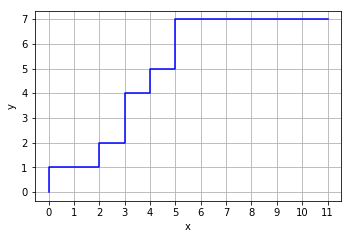

In [4]:
W1.plot_last_walk()

In [5]:
W2 = AntWalk(23, 31, seed = 7)
W2.run()
print("Mean: {}".format("%0.10f" % W2.mean()))
print("Standard Deviation: {}".format("%0.10f" % W2.std()))
print("Conditional Probability of {0}, given {1}: {2}".format(0.6, 0.2, "%0.10f" % W2.cond_prob(0.6, 0.2)))

Mean: 0.3538084816
Standard Deviation: 0.1369744135
Conditional Probability of 0.6, given 0.2: 0.0628945334


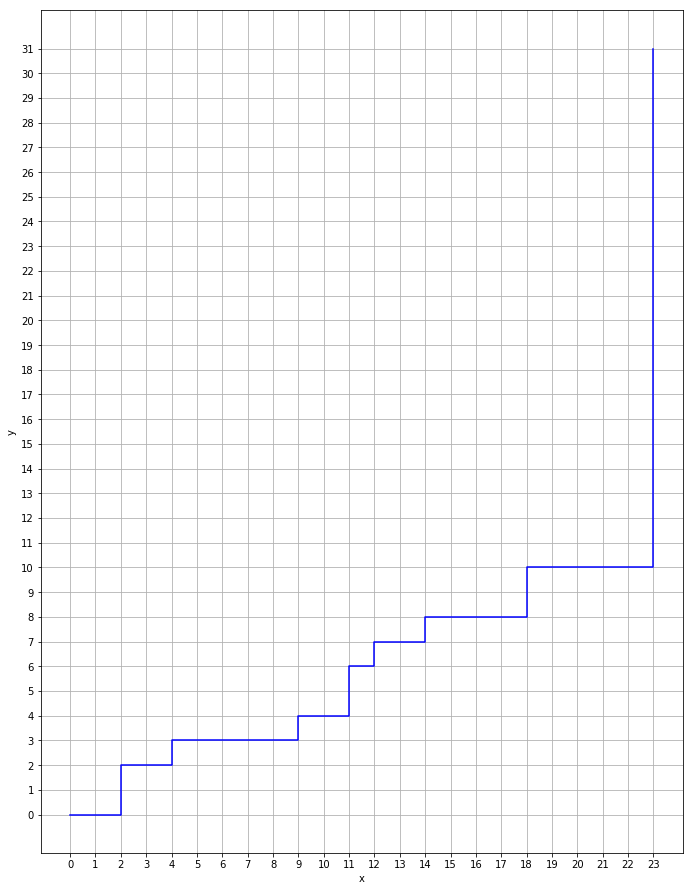

In [6]:
W2.plot_last_walk()

<h1>Question 2</h1>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from numpy.core import defchararray as dcarr
from scipy import stats
from math import sin, cos, sqrt, asin, radians

In [8]:
def grab_data(state, dtype = None):
    url = "https://stacks.stanford.edu/file/druid:py883nd2578/{}-clean.csv.gz".format(state)
    df = pd.read_csv(url, compression = 'gzip', header = 0, dtype = dtype)
    return df

In [9]:
mt_df = grab_data("MT")
vt_df = grab_data("VT")

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
mt_df.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'lat', 'lon', 'ethnicity', 'city', 'out_of_state',
       'vehicle_year', 'vehicle_make', 'vehicle_model', 'vehicle_style',
       'search_reason', 'stop_outcome_raw'],
      dtype='object')

In [11]:
mt_P_male = np.count_nonzero(mt_df.driver_gender == 'M') / mt_df.shape[0]

print("Proportion of traffic stops in MT involving male drivers: {}"\
      .format("%0.10f" % mt_P_male))

Proportion of traffic stops in MT involving male drivers: 0.6749749733


In [12]:
mt_arrest_inds = mt_df.is_arrested.nonzero()[0]
mt_oos_inds = mt_df.out_of_state.nonzero()[0]

mt_arrest_oos_inds = np.intersect1d(mt_arrest_inds, mt_oos_inds)

mt_P_arrest = mt_arrest_inds.size / mt_df.shape[0]
mt_P_arrest_cond_oos = mt_arrest_oos_inds.size / mt_oos_inds.size

print("Factor increase in traffic stop arrest likelihood in MT from OOS plates: {}"\
     .format("%0.10f" % (mt_P_arrest_cond_oos / mt_P_arrest)))

Factor increase in traffic stop arrest likelihood in MT from OOS plates: 1.1527770008


In [13]:
arrest_freq = np.empty((2, 2), dtype = float)
arrest_freq[0] = np.sum(mt_df.is_arrested), np.sum(vt_df.is_arrested)
arrest_freq[1] = np.sum(np.logical_not(mt_df.is_arrested)), np.sum(np.logical_not(vt_df.is_arrested))

arrest_marg_dist = np.sum(arrest_freq, axis = 1) / np.sum(arrest_freq)

arrest_exp_freq = np.outer(arrest_marg_dist, np.sum(arrest_freq, axis = 0))

chi2 = stats.chisquare(arrest_freq.flatten(), arrest_exp_freq.flatten())

print("Chi-Squared traffic stop arrest test statistic: {}"\
     .format("%0.10f" % chi2[0]))
print("Null hypothesis (P_Arrest_MT == P_Arrest_VT) satisfied: {}"\
     .format(chi2[1] > 0.05))

Chi-Squared traffic stop arrest test statistic: 956.7917466547
Null hypothesis (P_Arrest_MT == P_Arrest_VT) satisfied: False


In [14]:
mt_is_speed = mt_df.violation.str.upper().str.contains("SPEEDING")
mt_P_speed = np.count_nonzero(mt_is_speed) / mt_df.shape[0]

print("Proportion of traffic stops in MT involving speeding violations: {}"\
     .format("%0.10f" % mt_P_speed))

Proportion of traffic stops in MT involving speeding violations: 0.6581882834


In [15]:
mt_is_dui = mt_df.violation.str.upper().str.contains("DUI")
mt_P_dui = np.count_nonzero(mt_is_dui) / mt_df.shape[0]

vt_is_dui = vt_df.violation.str.upper().str.contains("DUI")
vt_P_dui = np.count_nonzero(vt_is_dui) / vt_df.shape[0]

print("Factor increase in traffic stop DUI likelihood in MT over VT: {}"\
     .format("%0.10f" % (mt_P_dui / vt_P_dui)))

Factor increase in traffic stop DUI likelihood in MT over VT: 1.0541430190


In [16]:
mt_df_slice = mt_df[["stop_date", "vehicle_year"]].dropna()
mt_df_slice = mt_df_slice.loc[mt_df_slice.vehicle_year.apply(lambda x: isinstance(x, (int, float)) or (isinstance(x, str) and x.isdigit()))]

mt_df_slice.stop_date = mt_df_slice.stop_date.apply(lambda x: pd.to_datetime(x, format = "%Y-%m-%d").year)
mt_df_slice.vehicle_year = mt_df_slice.vehicle_year.astype(float)

In [17]:
uniq_stop_dates = mt_df_slice.stop_date.unique()
avg_vehicle_years = np.empty(uniq_stop_dates.size, dtype = float)
for i in range(uniq_stop_dates.size):
    avg_vehicle_year = mt_df_slice.vehicle_year[mt_df_slice.stop_date == uniq_stop_dates[i]].mean()
    avg_vehicle_years[i] = avg_vehicle_year

slope, intercept, r_value, p_value, std_err = stats.linregress(uniq_stop_dates, avg_vehicle_years)

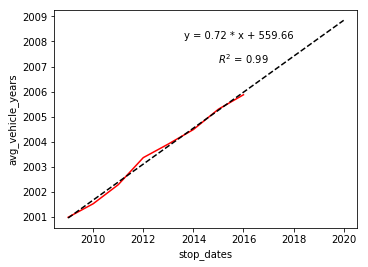

In [18]:
fig, ax = plt.subplots(subplot_kw = {'aspect': 'equal'})
ax.plot(uniq_stop_dates, avg_vehicle_years, color = 'red')

x = np.arange(uniq_stop_dates.min(), 2020 + 1)
y = intercept + slope * x
ax.plot(x, y, color = 'black', linestyle = '--')

ax.set_xlabel("stop_dates")
ax.set_ylabel("avg_vehicle_years")
ax.text(x[-2] - 1, y[-2], "y = {} * x {} {}".format("%0.2f" % slope, "+" if intercept > 0 else "-", "%0.2f" % intercept), ha = 'right')
ax.text(x[-2] - 2, y[-2] - 1, "$R^2$ = {}".format("%0.2f" % r_value ** 2), ha = 'right')
plt.show()

In [19]:
print("Average manufacture year of vehicles stopped in MT in 2020: {}"\
     .format("%0.10f" % y[-1]))
print("P-value of linear regression: {}"\
     .format("%0.10f" % p_value))

Average manufacture year of vehicles stopped in MT in 2020: 2008.8431659593
P-value of linear regression: 0.0000000561


In [20]:
stop_times = pd.to_datetime(np.append(mt_df.stop_time.dropna(), vt_df.stop_time.dropna()), format = "%H:%M")

uniq_stop_hours = stop_times.hour.unique()
total_stop_counts = np.empty(uniq_stop_hours.size, dtype = int)
for i in range(uniq_stop_hours.size):
    total_stop_count = np.count_nonzero(stop_times.hour == uniq_stop_hours[i])
    total_stop_counts[i] = total_stop_count

print("Difference in the total number of stops that occurred between min and max hours in both MT and VT: {}"\
      .format("%0.10f" % (total_stop_counts.max() - total_stop_counts.min())))

Difference in the total number of stops that occurred between min and max hours in both MT and VT: 95344.0000000000


In [21]:
mt_df_slice = mt_df[["county_name", "lat", "lon"]].dropna()
county_names = mt_df_slice.county_name.unique()
county_names.sort()
ell_center = np.empty((county_names.size, 2), dtype = float)
ell_semi_axes = np.empty((county_names.size, 2), dtype = float)
ell_area = np.empty(county_names.size, dtype = float)
R = 6371.0 # approximate radius of earth in km
np_radians = np.vectorize(radians)
for i in range(county_names.size):
    mt_lon_bounds = (mt_df_slice.lon >= -120) & (mt_df_slice.lon <= -100)
    mt_lat_bounds = (mt_df_slice.lat >= 40) & (mt_df_slice.lat <= 50)
    bool_matches = (mt_df_slice.county_name.str.match(county_names[i])) & mt_lat_bounds & mt_lon_bounds
    lons = mt_df_slice.lon[bool_matches]
    lats = mt_df_slice.lat[bool_matches]
    
    ell_center[i] = R * np_radians(np.array([lons.mean(), lats.mean()]))
    ell_semi_axes[i] = R * np_radians(np.array([lons.std(), lats.std()]))
    
    ell_area[i] = np.pi * ell_semi_axes[i].prod()

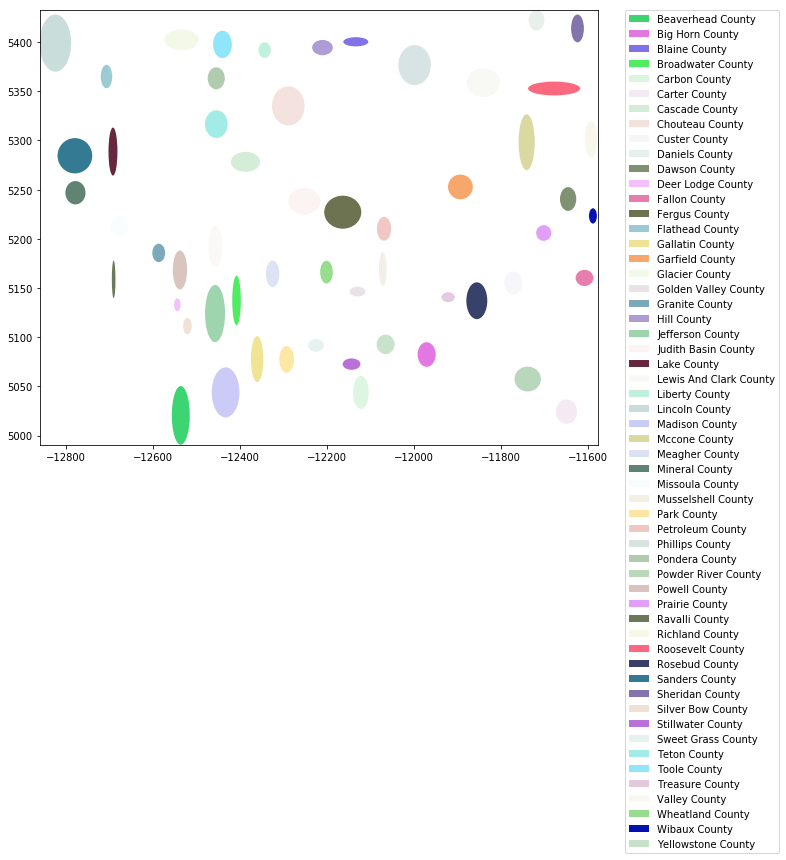

In [22]:
ells = [Ellipse(ell_center[i], *(2 * ell_semi_axes[i])) for i in range(county_names.size)]
fig, ax = plt.subplots(figsize = (10, 8))
for i, e in enumerate(ells):
    ax.add_patch(e)
    e.set(clip_box = ax.bbox,
          alpha = np.random.rand(),
          facecolor = np.random.rand(3),
          label = county_names[i])
ell_min = (ell_center - ell_semi_axes).min(axis = 0)
ell_max = (ell_center + ell_semi_axes).max(axis = 0)
ax.set_xlim(ell_min[0], ell_max[0])
ax.set_ylim(ell_min[1], ell_max[1])
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.show()

In [23]:
print("Area in sq. km of the largest county in MT: {}"\
      .format("%0.10f" % ell_area.max()))

Area in sq. km of the largest county in MT: 3316.1704278437
